In [1]:
%cd "/gscratch/xlab/alisaliu/hack-tokenizers"

/mmfs1/gscratch/xlab/alisaliu/hack-tokenizers


/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path
import json
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from utils import ensure_dir, read_predictions, read_merges_txt, mse, read_json, get_pair_to_byte_ratios, score_solution
from train_mixed_tokenizer import sample_from_unit_simplex
import seaborn as sns
import pandas as pd
import numpy as np
import string
import itertools

In [3]:
MIXTURE_TYPES = ['languages', 'code', 'domains']

In [4]:
from matplotlib import font_manager
import colorsys
import matplotlib.colors as mcolors

font_dir = ["../FONTS"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

plt.rcParams.update({
    "font.family": "Macho",
    "axes.linewidth": 1.5,
    "axes.edgecolor": "#333333",
    "axes.labelcolor": "#333333",
    "axes.titlecolor": "#333333",
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "legend.labelcolor": "#333333",
    "text.color": "#333333",
    "font.size": 14,
})

In [11]:
per_lang_exs = []
n = 112
mixture_type = 'languages'

experiment_dir = Path(f'data/mixed_{mixture_type}/n_{n}')

for test_id in tqdm(os.listdir(experiment_dir), desc=f'{mixture_type}, n={n}'):
    solved = False
    for T in [29757, 29776, 29778, 29780]:
        try:
            meta = read_json(experiment_dir / test_id / 'meta.json')
            truth = {k: v / sum(meta['byte_count'].values()) for k, v in meta['byte_count'].items()}
            pred = read_json(experiment_dir / test_id / f'solution6_pairs_{T}.json')['lang_vals']
            for lang in truth.keys():
                square_diff = (truth[lang] - pred[lang])**2
                per_lang_exs.append({
                    'square_diff': square_diff,
                    'lang': lang
                })
            break
        except FileNotFoundError:
            continue

languages, n=112: 100%|██████████| 100/100 [00:05<00:00, 17.07it/s]


In [12]:
df = pd.DataFrame(per_lang_exs)

In [14]:
np.mean(np.log10([s for s in df.loc[df['lang'] == 'ko'].square_diff]))

-7.019482242343728

In [18]:
np.mean(np.log10([s for s in df.loc[df['lang'] == 'zh'].square_diff]))

-6.052560229263357

In [24]:
df.lang.value_counts().keys()

Index(['eu', 'fy', 'da', 'ps', 'ja', 'ceb', 'sr', 'bg', 'tr', 'cs',
       ...
       'bo', 'or', 'lb', 'sl', 'no', 'de', 'ku', 'nl', 'nn', 'he'],
      dtype='object', name='lang', length=112)

In [27]:
avgs = {lang: np.mean(np.log10([s for s in df.loc[df['lang'] == lang].square_diff])) for lang in df.lang.value_counts().keys()}
{k: avgs[k] for k in sorted(avgs, key=avgs.get)}

{'ga': -8.858594621113687,
 'yi': -8.839582247296454,
 'is': -8.799912131177065,
 'cs': -8.778392657635054,
 'pl': -8.659580325435167,
 'sk': -8.522649509901504,
 'de': -8.44762278354748,
 'lv': -8.429652180168418,
 'sl': -8.377488569550662,
 'sv': -8.36375058312079,
 'gl': -8.293317809381989,
 'ku': -8.276784215042523,
 'et': -8.232139621187121,
 'lb': -8.210963532357324,
 'lo': -8.153311546300774,
 'uz': -8.151948883580923,
 'sq': -8.143573960752022,
 'ro': -8.136027428556371,
 'no': -8.120441948306441,
 'lt': -8.099788288273428,
 'tr': -8.074762642519623,
 'eu': -8.028532757994858,
 'id': -8.018568652232394,
 'nl': -7.974275651815015,
 'da': -7.868988232546588,
 'pnb': -7.818361488692164,
 'pt': -7.816938732330902,
 'it': -7.766746686054303,
 'hr': -7.759279130693959,
 'es': -7.740420489153422,
 'nn': -7.676724252058656,
 'vi': -7.650985157661598,
 'mg': -7.624071878215958,
 'fi': -7.605416037136901,
 'ca': -7.536273609038403,
 'eo': -7.487587895921429,
 'nds': -7.467962481178972,
 

# Main Experiments (§4)

In [9]:
mses = {m: defaultdict(list) for m in MIXTURE_TYPES + ['random', 'uniform']}
dummy_codes = [''.join(tup) for tup in itertools.product(string.ascii_lowercase, string.ascii_lowercase)]

for n in [5, 10, 30, 112]:
    for mixture_type in MIXTURE_TYPES:
        experiment_dir = Path(f'experiments/mixed_{mixture_type}/n_{n}')
        if os.path.exists(experiment_dir):
            for test_id in tqdm(range(100), desc=f'{mixture_type}, n={n}'):
                solved = False
                for T in [29757, 29776, 29778, 29780]:
                    try:
                        s = score_solution(experiment_dir / str(test_id), f'solution6_pairs_{T}.json')
                        mses[mixture_type][n].append(s)
                        solved = True
                        break
                    except FileNotFoundError:
                        continue
                if not solved:
                    print(f'mixed_{mixture_type}/n_{n}/{test_id}')
    
    # calculate random accuracy
    for _ in tqdm(range(10**6), desc=f'random, n={n}'):
        true = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
        pred = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
        s = mse(true, pred)
        mses['random'][n].append(s)

    # calculate accuracy of uniform guess
    for _ in tqdm(range(10**6), desc=f'uniform, n={n}'):
        true = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
        pred = {l: 1/n for l in dummy_codes}
        s = mse(true, pred)
        mses['uniform'][n].append(s)

uniform, n=112: 100%|██████████| 1000000/1000000 [02:41<00:00, 6179.10it/s]


In [10]:
for mixture_type in MIXTURE_TYPES + ['random', 'uniform']:
    for n in [5, 10, 30, 112]:
        if n in mses[mixture_type]:
            l = [np.log10(s) for s in mses[mixture_type][n]]
            print(f'{mixture_type}, n={n}: {np.around(np.mean(l), 2)} +- {np.around(np.std(l), 2)}')

languages, n=5: -7.3 +- 1.31
languages, n=10: -7.66 +- 1.04
languages, n=30: -7.73 +- 1.12
languages, n=112: -7.69 +- 1.28
code, n=5: -6.46 +- 0.79
code, n=10: -6.3 +- 0.64
code, n=30: -5.98 +- 1.11
domains, n=5: -3.41 +- 1.13
random, n=5: -1.39 +- 0.36
random, n=10: -1.84 +- 0.23
random, n=30: -2.7 +- 0.13
random, n=112: -3.82 +- 0.07
uniform, n=5: -1.67 +- 0.31
uniform, n=10: -2.14 +- 0.22
uniform, n=30: -3.01 +- 0.14
uniform, n=112: -4.12 +- 0.08


# Distribution shift analysis (§6.1)

In [17]:
experiment_dir = Path(f'experiments/mixed_languages_shift/n_10')
mses = {}

for e in [6, 7, 8, 9, 10]:
    mses[e] = defaultdict(list)
    for test_id in tqdm(range(100), desc=f'1e{e:02d}'):
        for T in [100, 300, 1000, 3000, 10000, 29772]:
            s = score_solution(experiment_dir / str(test_id), f'solution6_pairs_{T}_1e{e:02d}.json', num_bytes=10**e)
            mses[e][T].append(s)

1e10: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


In [18]:
D_col, T_col, score_col = [], [], []

for e, data in mses.items():
    for T, scores in data.items():
        for s in scores:
            D_col.append(10**e)
            T_col.append(T)
            score_col.append(s)

In [19]:
data = pd.DataFrame({'D': D_col, 'T': T_col, 'MSE': score_col})

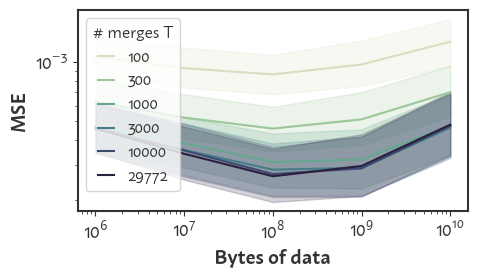

In [20]:
fig, ax = plt.subplots(figsize=(5,3))
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel('Bytes of data', fontweight='semibold')
ax.set_ylabel('MSE', fontweight='semibold')
sns.lineplot(data=data, x='D', y='MSE', hue='T', palette=sns.cubehelix_palette(start=.5, rot=-.75, n_colors=6))
ax.legend(title='# merges T', loc='upper left', fontsize=12, title_fontsize=12, handlelength=1)
plt.tight_layout()
plt.savefig('plots/shift_bytes_data_scaling.pdf', dpi=300)

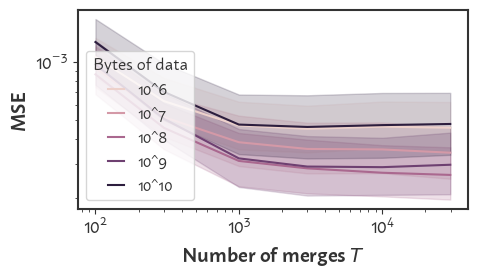

In [21]:
fig, ax = plt.subplots(figsize=(5,3))
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel('Number of merges $T$', fontweight='semibold')
ax.set_ylabel('MSE', fontweight='semibold')
data['e'] = [f'10^{int(np.log10(d))}' for d in data['D']]
sns.lineplot(data=data, x='T', y='MSE', hue='e', palette=sns.cubehelix_palette(n_colors=5))
ax.legend(title='Bytes of data', loc='lower left', fontsize=12, title_fontsize=12, handlelength=1)
plt.tight_layout()
plt.savefig('plots/shift_num_merges_scaling.pdf', dpi=300)

# Unaccounted-for languages analysis (§6.2)

In [22]:
experiment_dir = Path('experiments/mixed_languages/n_112')

In [25]:
mses = []
for test_id in tqdm(range(100)):
    test_id = str(test_id)
    for n_omit in [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
        solution_file = f'solution6_pairs_29778_langlist_omit{n_omit}.json'
        try:
            preds = read_predictions(experiment_dir / test_id / solution_file)
        except FileNotFoundError:
            continue
        
        meta = read_json(experiment_dir / test_id / 'meta.json')
        truth = {k: v / sum(meta['byte_count'].values()) for k, v in meta['byte_count'].items()}

        included_langs = [l.rstrip() for l in open(experiment_dir / test_id / f'langlist_omit{n_omit}.txt').readlines()]
        prob_omitted = sum([v for k, v in truth.items() if k not in included_langs])
        renorm_truth = {k: v for k, v in truth.items() if k in included_langs}
        renorm_truth = {k: v / sum(renorm_truth.values()) for k, v in renorm_truth.items()}
        assert len(renorm_truth) == 112 - n_omit
        
        pair_to_byte_ratio = get_pair_to_byte_ratios(experiment_dir / test_id)
        
        converted_preds = {}
        for lang, p in preds.items():
            converted_preds[lang] = p * pair_to_byte_ratio[lang]
        converted_preds = {k: v / sum(converted_preds.values()) for k, v in converted_preds.items()}
        
        s = mse(renorm_truth, converted_preds)
        
        mses.append({
            'test_id': int(test_id),
            'n_omit': n_omit,
            'prob_omitted': prob_omitted,
            'mse': s
        })

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


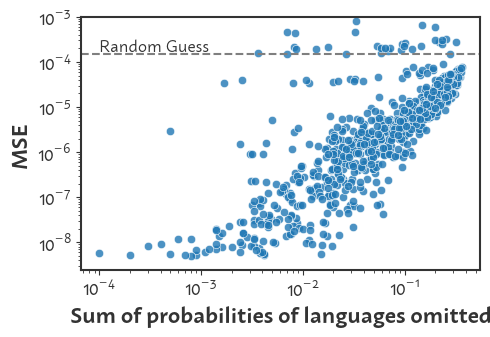

In [26]:
x = [ex['prob_omitted'] for ex in mses]
y = [ex['mse'] for ex in mses]
fig, ax = plt.subplots(figsize=(6.4*4/5,4.8*3/4))
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(x=x, y=y, alpha=0.8)
ax.set_xlabel('Sum of probabilities of languages omitted', fontsize=16, fontweight='semibold')
ax.set_ylabel('MSE', fontsize=16, fontweight='semibold')
ax.set_ylim(top=10**-3)

# Add horizontal line at log_10(-3.82)
log_rand_guess = -3.82
ax.axhline(y=10**log_rand_guess, color=sns.color_palette()[-3], linestyle='--', label='Random Guessing')

# Label for the horizontal line
ax.text(min(x), 10**log_rand_guess, 'Random Guess', fontsize=12, verticalalignment='bottom')

plt.tight_layout()
plt.savefig('plots/missing_lang.png', dpi=300)
plt.savefig('plots/missing_lang.pdf', dpi=300)